# Modelo de regresión logística para predecir incendios forestales en Argelia

In [36]:
#Importacion de librerias necesarias
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.impute import SimpleImputer
import pickle


%load_ext autoreload
%autoreload 2

import os
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating the classes

### Data Explorer

In [53]:
class DataExplorer:

    @staticmethod
    def explore_data(data):
        pass
    
    @staticmethod
    def plot_histograms(data):
        pass

    @staticmethod
    def plot_correlation_matrix(data):
        pass


    

### Model

In [46]:
class ForestFireModel:


    def __init__(self, path_file):
        
        self.path_file = path_file
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        
        self.pipeline = None
        self.best_model = None
        self.target_encoder = None

    
    def load_data(self):
        data = pd.read_csv(self.path_file ,sep=',', header='infer')
        return data
    

    def data_cleanup(self, output_file):
        data = self.load_data()
        data.rename(columns={' RH':'RH', ' Ws': 'Ws', 'Classes  ':'Classes', 'Rain ':'Rain'}, inplace=True)
        data['Classes'] = data['Classes'].str.strip()
        data_limpia = data.dropna()
        #Realizamos la transformacion de variables en el dataframe a su correcto formato
        columnas_categoricas = ['Classes', 'Region']
        columnas_enteras = ['day', 'month', 'year']
        columnas_continuas = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
        data_transformada = data_limpia.copy()
        data_transformada[columnas_categoricas] = data_limpia[columnas_categoricas].astype('category')
        data_transformada[columnas_enteras] = data_limpia[columnas_enteras].astype('int64')
        data_transformada[columnas_continuas] = data_limpia[columnas_continuas].astype('float64')
        data_transformada.to_csv(output_file, index=False)


    def preprocess_data(self, output_file):
        data_transformada = pd.read_csv(output_file)
        columnas_continuas = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
        y = data_transformada['Classes']
        data_transformada.drop(columns=['Classes'], inplace=True)
        X = data_transformada.select_dtypes(include=['float64', 'int64', 'category','object'])
        #Eliminamos las columnas que no añaden valor
        X = X.drop(columns=['day', 'month', 'year'])
        #Dividimos los datos
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        #para las variables continuas vamos a aplicar Normalizacion usando MinMaxScaler
        numericas_pipeline = Pipeline( steps=[
            ('minmax', MinMaxScaler()),
            ('scaler', StandardScaler()),
            ('PCA', PCA(n_components=0.95))
        ] )
        #para las variables cate vamos a aplicar OneHot
        catOHE_pipeline = Pipeline( steps=[
            ('OneHotEncoder', OneHotEncoder())
        ] )

        columnas_categoricas = ['Region']
        ct = ColumnTransformer(transformers=[
                ('numericas_continuas', numericas_pipeline, columnas_continuas),
                ('categoricas', catOHE_pipeline, columnas_categoricas)
                ])
        
        self.X_train = pd.DataFrame(ct.fit_transform(self.X_train), columns = ct.get_feature_names_out())
        self.X_test  = pd.DataFrame(ct.transform(self.X_test), columns = ct.get_feature_names_out())



    def train_model(self):
        """
        Train the model.

        Args:
            
        """
        modeloRL = LogisticRegression(penalty='l2',
                                    C=100,
                                    solver='liblinear',
                                    max_iter=1000,
                                    random_state=55)

        modeloRL.fit(self.X_train,np.ravel(self.y_train))

        self.best_model = modeloRL

        with open('../models/modelLR.pkl', 'wb') as f:
            pickle.dump(modeloRL, f)


    def predict(self, new_data):
        """
        Prediction of new data, returns the data in its categorical labels.

        Args:
            new_data: dataframe with new features to predict.
        """
        predictions = self.best_model.predict(new_data)
        #predictions = self.target_encoder.inverse_transform(predictions)
        return predictions


    def evaluate_model(self):
        """
        Model evaluation on test set.
        
        """
        y_pred = self.best_model.predict(self.X_test)
        cm = metrics.confusion_matrix(self.y_test, y_pred)
        print("Confusion Matrix:")
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.show()
        
        report = metrics.classification_report(self.y_test, y_pred)
        print("Classification Report:")
        print(report)

        print('accuracy-test', metrics.accuracy_score(self.y_test, y_pred))



    def cross_validate_model(self):
        scores = cross_val_score(self.pipeline, self.X_train, self.y_train, cv=5)
        print("Average Accuracy with CV:", np.mean(scores))
        return self





### Executing the code

In [47]:
file_path = '../data/Algerian_forest_fires_dataset_UPDATE_RegionAdd.csv'
m_lr = ForestFireModel(file_path)

In [48]:
output_file = '../data/processed/Algerian_forest_fires_dataset_clean.csv'
m_lr.data_cleanup(output_file)
m_lr.preprocess_data(output_file)

In [49]:
m_lr.train_model()

In [50]:
m_lr.best_model

LogisticRegression(C=100, max_iter=1000, random_state=55, solver='liblinear')

In [51]:
m_lr.predict(m_lr.X_test)

array(['fire', 'fire', 'not fire', 'not fire', 'fire', 'not fire',
       'not fire', 'fire', 'not fire', 'not fire', 'not fire', 'fire',
       'fire', 'fire', 'fire', 'not fire', 'not fire', 'not fire', 'fire',
       'fire', 'not fire', 'not fire', 'fire', 'not fire', 'fire', 'fire',
       'fire', 'fire', 'not fire', 'fire', 'fire', 'not fire', 'fire',
       'fire', 'not fire', 'not fire', 'not fire', 'fire', 'not fire',
       'not fire', 'fire', 'not fire', 'fire', 'not fire', 'fire', 'fire',
       'fire', 'not fire', 'fire'], dtype=object)

Confusion Matrix:


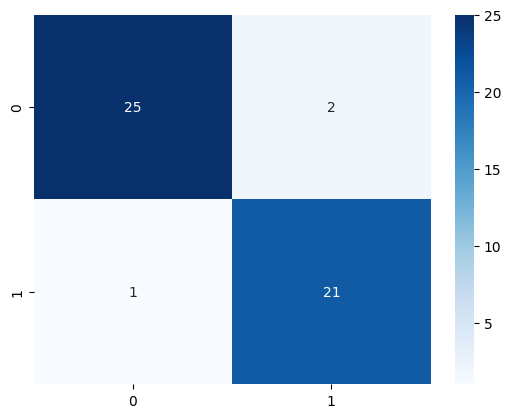

Classification Report:
              precision    recall  f1-score   support

        fire       0.96      0.93      0.94        27
    not fire       0.91      0.95      0.93        22

    accuracy                           0.94        49
   macro avg       0.94      0.94      0.94        49
weighted avg       0.94      0.94      0.94        49

accuracy-test 0.9387755102040817


In [52]:
m_lr.evaluate_model()